<a href="https://colab.research.google.com/github/KY-39/platform_udt3/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9_%D0%9B%D1%83%D0%BA%D0%BE%D0%B9%D0%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ООО "Университет Цифровых Технологий платформа 3"

###Подключаем необходимые модули.

In [2]:
from tensorflow.keras.models import Sequential, load_model # Подлючаем класс создания модели Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, LSTM, Conv1D # Подключаем слои
from tensorflow.keras.optimizers import Adam, RMSprop # Подключаем оптимизатор Adam
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import tensorflow as tf # импортируем tensorflow

# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # для построения матрицы ошибок
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # для нормализации данных

import numpy as np # Подключаем библиотеку numpy
import pandas as pd # Библиотека pandas
import zipfile # для работы с архивами zip
import matplotlib as mpl
import matplotlib.pyplot as plt #Отрисовка изображений

import os
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1bdbbef62ed8b4aa9d255787c2e493d01ee9f1c0e0b54a847e56670643bbd746
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
#запускаем - подключаем Google Drive - В случае если будет необходимость сохранять обученные модели.
#после запуска переходим по ссылке, которая появится, для идентификации
#копируем оттуда код authorization code и вставляем здесь в окошко
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Прогнозирование акций Лукойл

### Ссылка на сревнование: 
https://www.kaggle.com/t/955ebc36acc64c7ba29da4136f53f4eb


Вход на соревнование. Перейдя на сайт, справа находим чёрную кнопку Join Competition. Нажимаем, читаем правила участия (Университет Цифровых Технологий платформа 3 Rules), соглашаемся с условиями соревнований, нажимая: I Understand and agree.

###Устанавливаем ключ Каггл, чтобы участвовать в соревнованиях. Это нужно сделать один раз.
Нужно зарегистрироваться на Каггл (https://www.kaggle.com/) и скачать ключ для взаимодействия с API соревновательной системы Каггла. После регистрации, справа появятся Ваши имя и фамилия - ссылка на персональную страницу. Нажмите на них. Когда страница загрузится, справа увидите Account. Нажимаете на надпись, затем прокручиваете страницу вниз, до вкладки API, там нажимаете Create New API Token. Ключ - это файл kaggle.json, который скачается после нажатия. Нужно скопировать его в папку Google Drive, предварительно её создав: My Drive/datasets/kaggle/ (из Колаба её адрес, который будем указывать для загрузки, такой: /content/drive/My Drive/datasets/kaggle/).

In [4]:
def Init_Kaggle():
    try:
        # Создаём правильную папку для ключа Каггл
        # в Колабе, она должна быть такой по требованию Каггл
        !mkdir ~/.kaggle
        # переходим в папку, теперь это путь по умолчанию
        %cd ~/.kaggle
        # запускаем - подключаем Google Drive - будем скачивать с него, так намного быстрее и удобнее
        # после запуска переходим по ссылке, которая появится, для идентификации
        # копируем оттуда код authorization code и вставляем здесь в окошко
        drive.mount('/content/drive')
        # нужно зарегистрироваться на Каггл и скачать ключ для взаимодействия с API
        # соревновательной системы Каггла kaggle.json. Нужно скопировать его в папку
        # Google Drive, предварительно её создав: /content/drive/My Drive/datasets/kaggle/
        !cp '/content/drive/My Drive/datasets/kaggle/kaggle.json' '/root/.kaggle/kaggle.json'
        # выводим версию API Kaggle:
        !kaggle --version
        !ls
        print(' Ключи Kaggle успешно установлены! ')
    except:
        print(' При установке ключей Kaggle произошла ошибка! ') 

In [5]:
def Load_data_from_Kaggle():
    # считаем заполненную базу данных из kaggle
    %cd ~/.kaggle
    print('скачиваем данные с Каггл:')
    !kaggle competitions download -c udt-3-timeseries
    print('загружаем из архива, распаковываем:')
    z = zipfile.ZipFile('udt-3-timeseries.zip', 'r')
    z.extractall()
    # удаляем архив, чтобы не занимал место на диске
    !rm udt-3-timeseries.zip
    #Считываем данные с помощью pandas из двух файлов
    l_data1 = pd.read_csv('18_19.csv', sep=';')
    l_data2 = pd.read_csv('16_17.csv', sep=';')
    xTest = np.load('x_test.npy')
    #Объединяем базы из двух файлов
    lukoil_data = l_data2.append(l_data1)
    lukoil_data.drop(columns=['DATE', 'TIME'], axis=1, inplace=True)
    return lukoil_data, xTest

In [6]:
Init_Kaggle() # устанаовка ключей Kaggle

/root/.kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kaggle API 1.5.12
kaggle.json
 Ключи Kaggle успешно установлены! 


In [7]:
lukoil_data, xTest = Load_data_from_Kaggle() # считаем  базу данных из kaggle
lukoil_data.head()

/root/.kaggle
скачиваем данные с Каггл:
  0% 0.00/7.49M [00:00<?, ?B/s]
100% 7.49M/7.49M [00:00<00:00, 91.9MB/s]
загружаем из архива, распаковываем:


,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


### Анализ и обработка данных.

In [8]:
def Normalization_data(lukoil_data): # нормализуем данные
    global xScaler
    global yScaler
    global xLen
    global vallen

    xLen = 300                                                # Анализируем по xLen прошедшим точкам 
    valLen = 30000                                            # Используем valLen записей для проверки
    lukoil_data = np.array(lukoil_data)
    trainLen = lukoil_data.shape[0]-valLen  # Размер обучающей выборки
    xTrain,xTest = lukoil_data[:trainLen], lukoil_data[trainLen+xLen+2:] # Делим данные на обучающую и валидационную выборки 
    # Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
    xScaler = MinMaxScaler()
    xScaler.fit(xTrain)
    xTrain = xScaler.transform(xTrain)
    xTest = xScaler.transform(xTest)
    # Сделаем reshape,т.к. у нас только один столбец по одному значению
    yTrain,yTest = np.reshape(lukoil_data[:trainLen,3],(-1,1)), np.reshape(lukoil_data[trainLen+xLen+2:,3],(-1,1)) 
    yScaler = MinMaxScaler()
    yScaler.fit(yTrain)
    yTrain = yScaler.transform(yTrain)
    yTest = yScaler.transform(yTest)
    print('Данные нормализованы успешно! ')
    return xTrain,xTest,yTrain,yTest

In [9]:
def Timeseries_data(xyTrain, parametr = 20): # метод для выборок с помощью генератора
    xTrain = xyTrain[0]
    xTest = xyTrain[1]
    yTrain = xyTrain[2]
    yTest = xyTrain[3]
    # С помощью генератора создаем выборку для обучения
    trainDataGen = TimeseriesGenerator(xTrain, yTrain,           # Параметров нашей выборки
                                length=xLen, stride=1,        # Для каждой точки (из промежутка длины xLen)
                                batch_size=parametr)                # Размер batch, который будем подавать для модели
    # Аналогичный генератор создадим для валидации при обучении
    testDataGen = TimeseriesGenerator(xTest, yTest,
                                length=xLen, stride=1,
                                batch_size=parametr)
    print('Данные успешно сформированы! ')
    return trainDataGen, testDataGen

In [10]:
def plot_train_history(history, title): # метод для отрисовки графиков ошибки
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Ошибка на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Ошибка на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

In [11]:
Data_normal = Normalization_data(lukoil_data)

Данные нормализованы успешно! 


In [12]:
trainDataGen, testDataGen = Timeseries_data(Data_normal)

Данные успешно сформированы! 


In [13]:
print(trainDataGen[0][0].shape)
print(trainDataGen[0][1].shape)

(20, 300, 5)
(20, 1)


Создадим модель нейронной сети на основе одномерной свертки.

In [14]:
# Создадим модель
def Conv1D_model():
    model = Sequential()
    model.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
    model.add(Flatten())
    model.add(Dense(100, activation="linear"))
    model.add(Dense(1))

    model.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))
    return model


In [15]:
# Обучаем модель полученными данными
model_Convalution = Conv1D_model()
history = model_Convalution.fit(trainDataGen,
                    epochs=10, 
                    validation_data=testDataGen,
                    verbose=1)

Epoch 1/10
22579/22579 [==============================] - 200s 8ms/step - loss: 0.0357 - val_loss: 0.4222
Epoch 2/10
22579/22579 [==============================] - 186s 8ms/step - loss: 9.7621e-04 - val_loss: 1.2531e-04
Epoch 3/10
22579/22579 [==============================] - 184s 8ms/step - loss: 2.8364e-04 - val_loss: 2.7075e-05
Epoch 4/10
22579/22579 [==============================] - 184s 8ms/step - loss: 5.0870e-04 - val_loss: 2.0597e-04
Epoch 5/10
22579/22579 [==============================] - 182s 8ms/step - loss: 9.4154e-05 - val_loss: 9.6891e-05
Epoch 6/10
22579/22579 [==============================] - 182s 8ms/step - loss: 8.2759e-05 - val_loss: 2.4861e-04
Epoch 7/10
22579/22579 [==============================] - 182s 8ms/step - loss: 5.6236e-05 - val_loss: 5.0132e-05
Epoch 8/10
22579/22579 [==============================] - 182s 8ms/step - loss: 3.1616e-05 - val_loss: 2.1594e-05
Epoch 9/10
22579/22579 [==============================] - 181s 8ms/step - loss: 4.4043e-05 - val

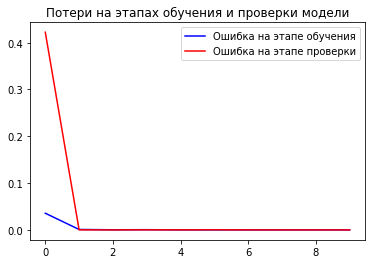

In [16]:
plot_train_history(history, 'Потери на этапах обучения и проверки модели')

In [17]:
# сохраним модель при необходимости
model_Convalution.save('/content/drive/MyDrive/datasets/model_Convalution.h5') 

In [18]:
# загрузим сохраненную модель при необходимости
model_Convalution = load_model('/content/drive/MyDrive/datasets/model_Convalution.h5')

### Создадим предсказание обученной модели.

In [19]:
# получим прогноз на тестовой выбоке
def Predict_Model(xTest,currModel): 
    #Предсказываем ответ сети по тестовой выборке и возвращаем исходные масштаб данных, до нормализации
    predTest = yScaler.inverse_transform(currModel.predict(xTest[0]))
    print('Созданы спрогнозированные значения, на части выделенных тестовых данных ')
    return predTest

In [20]:
# оформить результат и отправить на Kaggle
def Send_results(pred_data_my):
    try:
        predUnscaled = pred_data_my.squeeze()
        # создаём датафрейм в нужном формате
        submission = pd.DataFrame({"Id":range(1,len(predUnscaled)+1),"Label":predUnscaled})
        submission.head()
        # сохраняем его как csv
        submission = submission.to_csv('./Submission_Shared_Lukoil.csv', sep=',', index=False, header=True)
        # отправляем на соревнование
        !kaggle competitions submit -c udt-3-timeseries -f Submission_Shared_Lukoil.csv -m "Message"
        print('\n Расчитанные данные успешно отправлены! ')
    except:
        print('Отправка расчетных данных не прошла! ')

In [21]:
prediction_data = Predict_Model(xTest, model_Convalution) # получим прогноз на тестовой выбоке

Созданы спрогнозированные значения, на части выделенных тестовых данных 


In [22]:
Send_results(prediction_data) # оформить результат и отправить на Kaggle

100% 433k/433k [00:00<00:00, 530kB/s]
Successfully submitted to Университет Цифровых Технологий платформа 3
 Расчитанные данные успешно отправлены! 


###Переходим по ссылке, чтобы увидеть таблицу лидеров.

https://www.kaggle.com/c/udt-3-timeseries/leaderboard

# Литература:



1. Шмойлова Р. А. "Общая теория статистики: Учебник." — М.: Финансы и статистика, 2002.
2. Мишулина О. А. "Статистический анализ и обработка временных рядов." — М.: МИФИ, 2004. — С. 180. — ISBN 5-7262-0536-7

3. Губарева Е.А. "Нейронные сети в анализе временных рядов." ФГБОУ ВО "Государственный университет управления"

4. Франсуа Шолле, «Глубокое обучение на Python»

5. Орельен Жерон, «Прикладное машинное обучение с помощью Scikit-Learn, Keras и TensorFlow», 2-е издание

6. Автокорреляция.
https://dic.academic.ru/dic.nsf/ruwiki/761557

7. LSTM - сети долгой краткосрочной памяти. https://habr.com/ru/company/wunderfund/blog/331310/

8. Основные оценки точности прогнозирования временных рядов. https://www.mbureau.ru/blog/osnovnye-ocenki-tochnosti-prognozirovaniya-vremennyh-ryadov







